### Notebook setup

#### Import shunpiker pre-set packages and modules
 
For an introduction to python packages and modules, see https://realpython.com/python-modules-packages/#python-packages.    

In [1]:
# import shunpiker pre-set packages and modules
%run shunpiker_modules.py

scanpy==1.8.2 anndata==0.7.6 umap==0.5.2 numpy==1.20.3 scipy==1.7.1 pandas==1.3.4 scikit-learn==1.0.1 statsmodels==0.13.0 python-igraph==0.9.8 pynndescent==0.5.5
phenograph== 1.5.7


💡 **Hint:** Use the code below ONLY if you need to install extra packages

In [2]:
#import sys
#!{sys.executable} -m pip install scrublet

#### Set notebook parameters

[`%matplotlib inline`](https://ipython.readthedocs.io/en/stable/interactive/tutorial.html#magics-explained) sets output of plotting commands to be displayed directly below the code cell that produced it.


<a id='part_1'></a>

In [2]:
# display plot directly below code cell
%matplotlib inline

## Sample "clean-up"

### Read in scRNA-seq raw counts into a python object

❗ Choose between [cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/overview) and [SEQC](https://github.com/dpeerlab/seqc) data format for your input

Both data inputs will be converted into a scRNA-seq friendly python object called an AnnData object. The AnnData object is  is made up of several components. For a more detailed explanation, see https://anndata.readthedocs.io/en/latest/anndata.AnnData.html#anndata.AnnData. 

Once you execute either of the input commands below, you should be able to access:
- counts: `adata.X` + Run
- gene names: `adata.var` + Run
- cell index and other annotation: `adata.obs` + Run

#### Input SEQC data

🕹️  Provide the path to your raw data and the name of your sample

In [3]:
# type path to your SEQC data folder (replace example path with your path)
path_to_seqc_data = '../data/'

In [4]:
# type name of your file (replace example file name with your file name)
sample_name = '3004_MAIT_patients_IGO_12381_55_dense.csv'

In [5]:
# convert your selected sample/samples into one anndata object  
adata = import_seqc_data(path_to_seqc_data, sample_name)
adata.X = np.array(pd.DataFrame(adata.X).fillna(0)) # fill NAs with 0s

In [6]:
# randomize the order of cells for plotting
np.random.seed(42) 
index_list = np.arange(adata.shape[0])
np.random.shuffle(index_list)
adata = adata[index_list]

❗Using the line below you can check the number of cells (x, ) and genes ( ,y) that you have in your sample. 

This is a good sanity check after every filtering step to make sure the filters have been applied properly.

### Calculate quality control metrics for your sample before preprocessing

To start, we will calculate some standard quality control (QC) metrics using the `calc_QC_metrics()` function that is defined within the `shunpiker_modules.py` file. The QC metrics calculated include total counts, number of genes, and ribosomal and mitochondrial fraction on a per cell basis.

In [7]:
# caclutate QC metrics for your sample
calc_QC_metrics(adata)

Trying to set attribute `.obs` of view, copying.


❗To check if the QC metrics are now available for your sample, you can run the command below and inspect the column names.

In [8]:
# show top 5 rows from sample metadata (stored in adata.obs)
adata.obs.head()

n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
cell_barcodes                                                               
240628337859893               1387                 7.235619        4022.0   
226746063869678               1169                 7.064759        3579.0   
232313280715995               1825                 7.509883        6140.0   
241109193870572               2399                 7.783224        7693.0   
239939129293550               1326                 7.190676        3759.0   

                 log1p_total_counts  pct_counts_in_top_50_genes  \
cell_barcodes                                                     
240628337859893            8.299783                   39.632024   
226746063869678            8.183118                   41.017044   
232313280715995            8.722743                   39.788274   
241109193870572            8.948196                   31.210191   
239939129293550            8.232174                   44.932163   

                 pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
cell_barcodes                                                               
240628337859893                    53.754351                    63.998011   
226746063869678                    55.909472                    67.421067   
232313280715995                    53.501629                    63.908795   
241109193870572                    41.869232                    52.697257   
239939129293550                    56.185156                    64.618250   

                 pct_counts_in_top_500_genes  original_total_counts  \
cell_barcodes                                                         
240628337859893                    77.946295                 4022.0   
226746063869678                    81.307628                 3579.0   
232313280715995                    75.944625                 6140.0   
241109193870572                    67.385935                 7693.0   
239939129293550                    78.026071                 3759.0   

                 log10_original_total_counts  mito_frac  RBP_frac  
cell_barcodes                                                      
240628337859893                     3.604442   0.075087  0.335654  
226746063869678                     3.553762   0.081028  0.347304  
232313280715995                     3.788168   0.067427  0.317264  
241109193870572                     3.886096   0.031717  0.189523  
239939129293550                     3.575072   0.156691  0.241554

### Data "clean-up": identification of doublet cells

We will use the scanpy implementation ([`scanpy.external.pp.scrublet`](https://scanpy.readthedocs.io/en/latest/generated/scanpy.external.pp.scrublet.html#scanpy-external-pp-scrublet)) of the [scrublet package](https://github.com/swolock/scrublet) to identify doublet cells. This command will use the default parameters of `scanpy.external.pp.scrublet`, however, if you are feeling brave or disagree with the predicted doublets you can use this [example notebook](https://github.com/swolock/scrublet/blob/master/examples/scrublet_basics.ipynb) to alter any of these parameters.

In [9]:
# run scanpy implementation of the scrublet package to identify doublet cells
sc.external.pp.scrublet(adata)

/home/kousaa/miniconda3/envs/AK011_py38/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 11.1%


### Data "clean-up": removal of not expressed genes

Genes with zero counts across all cells will not provide any biological insight, but rather delay some of the downstream processing steps, thus we choose to remove genes that are not expressed in any cells. You can make this step more stringend by asking genes to be expressed in at least N number of cells.

In [10]:
# remove genes that are not expressed in any cells (remove columns with all 0s)
sc.pp.filter_genes(adata, min_cells=1)

In [11]:
adata.shape

(12427, 18249)

### Data "clean-up": removal of rRNA

Ribosomal protein (RBP) RNA often constitutes between 20-50% of your counts. Variation in their expression can therefore highly affect the outcome of your visualization algorithms and differential gene expression analyses. Our experience is that expression levels of RBP RNA often cannot be reproduced or validated, and are moreover difficult to interpret. One can therefore decide to remove these genes from the data altogether.

In [12]:
adata = remove_RBs(adata)

### Data "clean-up": data normalization

RNA counts generally vary linearly with library size: RNA molecules have a steady concentration rather than a steady absolute number (Additional variation suggests biological variation in gene expression among your cells). Therefore, it is usually appropriate to normalize each cell to the same total library size, thereby converting RNA counts to a relative rather than absolute count. Below a random gene is plotted against library size to show that expression, at least if not variable between cell types in your sample, changes according to library size. We take a gene with a minimum gene expression of 1, because trends in genes with low mean expression are occluded by noise. Run the cell below a few times to inspect the general trend between gene expression and library size. Note that scRNA-seq data is highly noisy, and the correlation will therefore be noisy as well in genes with lower expression.

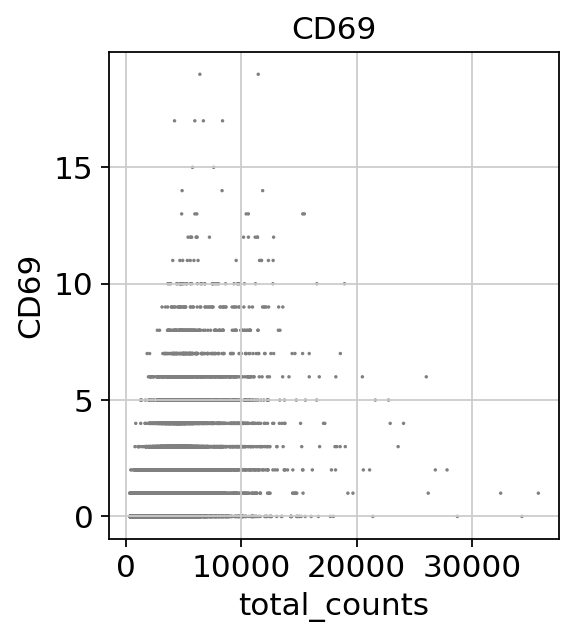

In [13]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
observe_library_size_effect(adata)

An alternative method to normalize data is using SCRAN that applies a similar principle to common normalization methods in bulk RNA data.

Here we will normalize to a total library size of 10,000. Scanpy will update our count matrix (adata.X) automatically with the normalized counts.

In [14]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4)

Trying to set attribute `.obs` of view, copying.


### Data "clean-up": log-transformation

Log transformation makes changes in expression relative rather than absolute (e.g. it looks at doubling (when using log2) of expression rather than increase of n counts in expression). It makes the differences between highly and lowly expressed genes smaller, and limits the effects of highly expressed genes on your data analysis. It is often considered a default part of preprocessing, but can occasionally be better left out. The desired effect of a log-transformation is that it brings out biological differences between your cell populations better. <br>
Scanpy's log transformation function takes the natural logarithm of each (count + 1), and updates your count matrix (adata.X): 

In [15]:
sc.pp.log1p(adata)

### Let's have a look at our data

UMAP embedding gives us a two-dimensional representation of our data, based on the similarities/differences among the cells in a higher-dimensional space. Each type of mapping has its own strenghts and weaknesses, thus it can be useful to take a look at different mappings. Using a selection of principal components before UMAP will not only shorten computation time, but also reduces noise.

In [16]:
rng = np.random.RandomState(42)
adata = sc.tl.pca(adata, n_comps=200, copy = True, svd_solver='arpack', random_state=rng)

We can visualize the percentage of variance explained by each PC. Based on this figure, we will select a number of principal components to use in the rest of our analysis. 

<function matplotlib.pyplot.show(close=None, block=None)>

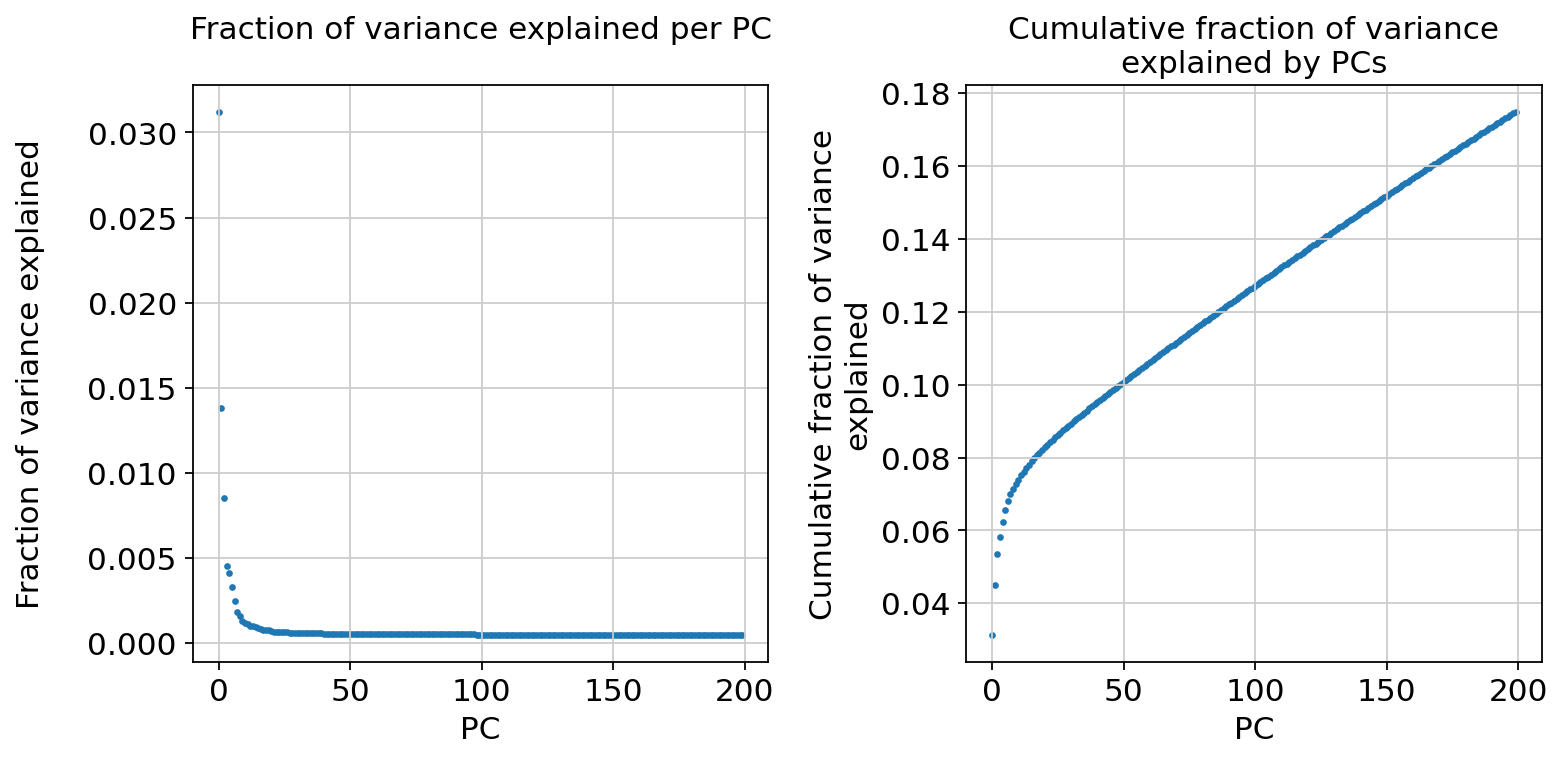

In [17]:
observe_variance(adata)

❗ We want to include all the principal components before the 'knee point' (the point where the fitted curve would change slope the most), because these likely represent important sources of variance in our data. To try to avoid eliminating any relevant but small sources of variance, we will choose a number of PCs slightly to the right of the knee point. 

🕹️  Replace the number below with your selection and run PCA again.

In [39]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=25, svd_solver='arpack', random_state=rng)

We will now run UMAP. When dealing with a very large dataset, it might be useful to use a perplexity higher than the default (`n_neighbors=15`). The command below will automatically use our PCA as a basis for calculating the embedding.

In [40]:
sc.pp.neighbors(adata, n_neighbors=15)

In [41]:
sc.tl.umap(adata)

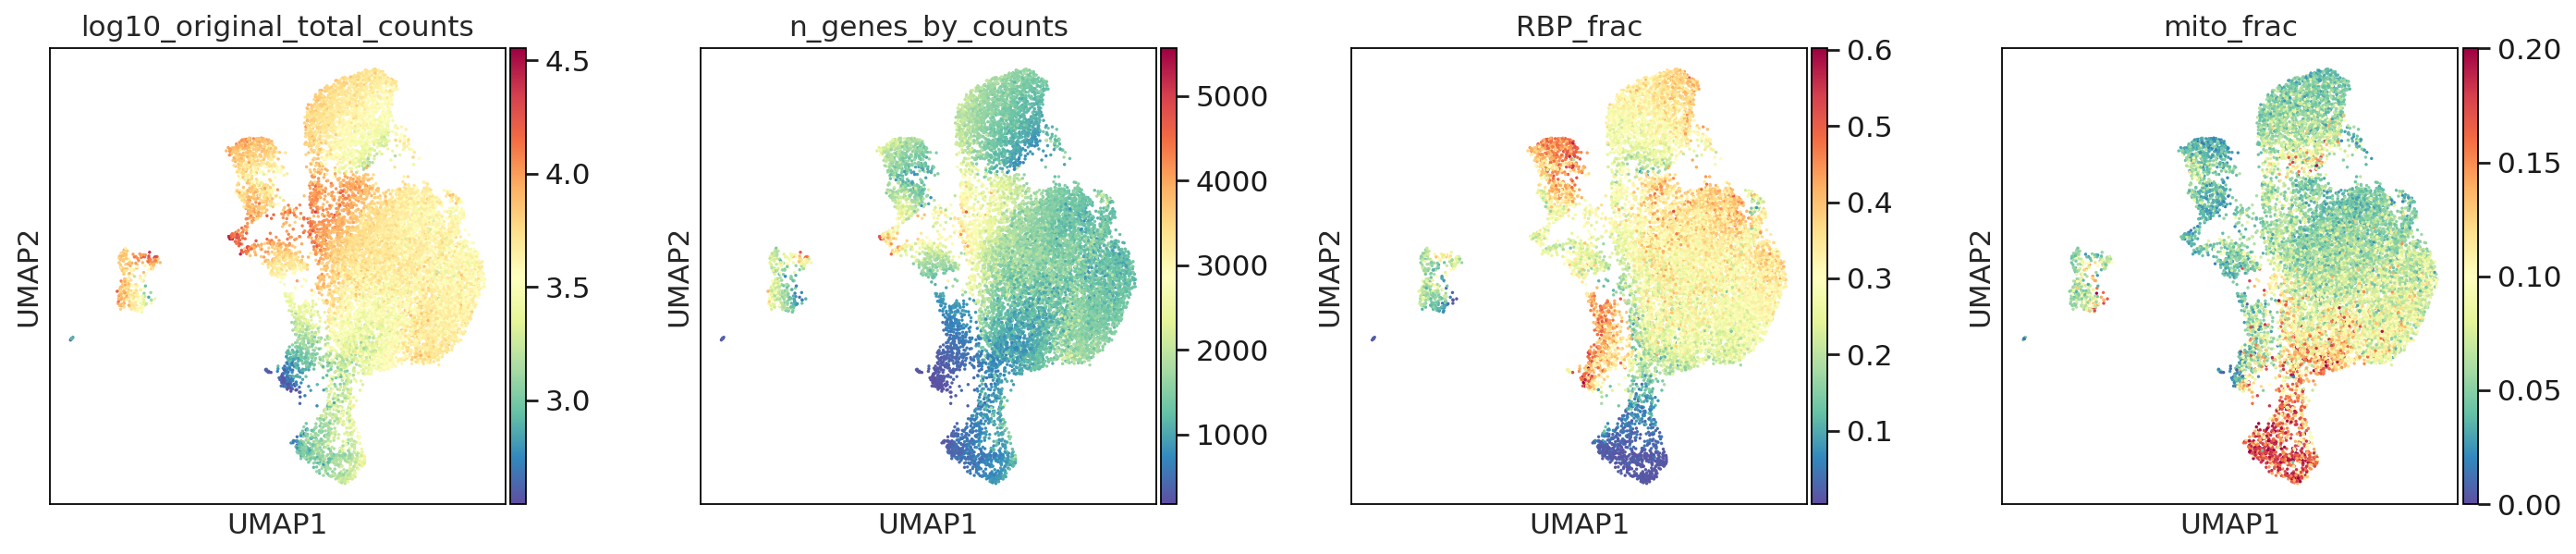

In [42]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
# plot major canonical markers as a sanity check
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

🕹️ Inspect canonical markers of your choice

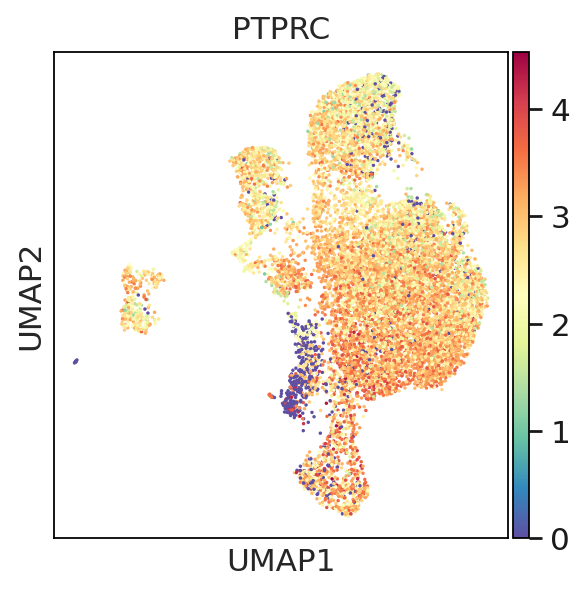

In [43]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
# plot major canonical markers as a sanity check
sc.pl.umap(
    adata, 
    color=['PTPRC'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=5,
    wspace = 0.3,
    sort_order = False
)

❗ **Does your data look well distinguished?** If yes, move ahead. If no, maybe try to increase the number of principal components you used, and rerun the last bits of code.

### Run unsupervised clustering analysis using PhenoGraph

Next, we will filter out cells that we think are either dying cells or empty droplets. Both are characterized by low library size, dying cells additionally have relatively high percentages of mitochondrial RNA. Rather than using cutoffs, we remove cells by cluster. This prevents us from taking out cells that belong to a biologically relevant cluster, despite having e.g. low library size or high mitochrondrial RNA. It furthermore ensures that we take out all cells with a phenotype similar to what we think are cells that should be taken out, even if they happen not to exceed a possible cutoff we would have otherwise chosen. We can furthermore remove clusters that we are not interested in, such as doublets and contaminants.

For clustering, we use [PhenoGraph](https://www.sciencedirect.com/science/article/pii/S0092867415006376). This is a highly robust graph-based clustering algorithm that was designed for single cell data. Your choice of k (number of nearest neighbors to use for graph construction) can affect the number of clusters and their size.

❗ How to select a number for neighbour cells (k) for fairly robust clustering.

Calculate clustering characteristics for a range of ks (5 to 155), by a step of 5.

Inspect the following clustering metrics:
- Minimum number of k for a connected graph.
- Changes in Q-modularity score (see PhenoGraph paper) for different ks. The Q-modularity usually drops quickly in the beginning (due to swiftly increasing connectedness when increasing a low k), and only slightly decreases after a certain point. However, in the case of homogeneous data with little structure, you might see a constant rapid decay in Q score. The plot below is not needed for a good choice of k, but is informative about the modularity of your data.
- Similarity/difference in cluster assignments between the different ks. We will use the Rand index to this end. The Rand index algorithm compares to clusterings by testing for every pair of cells, whether or not they were both clustered together or separately in both clusterings. E.g. if two cells were not in the same cluster in clustering 1, but were clustered together in clustering 2, this will decrease the Rand score. Alternatively, if they were in separate clusters in both cases, or in the same cluster in both cases, this will increase the score. The Rand index ranges from 0 to 1, with 1 indicating identical cluster assignments. We will calculate the Rand indices for all pairs of k and visualize the Rand indices using a heatmap, with our chosen range of k in the rows and columns, and the color indicating similarity in cluster assignments (red=high similarity, blue=low similarity). We can use the heatmap to find a region of ks where the clustering is fairly similar between runs (e.g. an index around 0.8 or higher). Within that 'robust region', we should choose a low k to retain as much resolution as possible.

⏳ This step might take a while so be patient

In [23]:
# calculate clustering characteristics for a range of ks (5 to 155), by a step of 5.
ks = np.arange(5,155,5)
cluster_chars = [calc_clustering_characteristics(k, adata.obsm['X_pca']) for k in ks];

Finding 5 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 111.9449052810669 seconds
Jaccard graph constructed in 19.694323539733887 seconds
Wrote graph to binary file in 0.0902101993560791 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.940774
Louvain completed 21 runs in 17.362711191177368 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 168.49240398406982 seconds
Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 8.752237558364868 seconds
Jaccard graph constructed in 19.686582803726196 seconds
Wrote graph to binary file in 0.22648167610168457 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.875232
After 3 runs, maximum modularity is Q = 0.876388
Louvain completed 23 runs in 21.295394897460938 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 67.15158104896545 seconds
Fi

Wrote graph to binary file in 2.4951171875 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.807166
Louvain completed 21 runs in 48.08803939819336 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 155.97111010551453 seconds
Finding 90 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 9.667454242706299 seconds
Jaccard graph constructed in 280.3838653564453 seconds
Wrote graph to binary file in 2.266835927963257 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.805442
Louvain completed 21 runs in 41.137094020843506 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 352.8069236278534 seconds
Finding 95 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 9.28325343132019 seconds
Jaccard graph constructed in 86.7229859828949 seconds
Wrote graph to binary file in 2.370079755783081 seconds
Running

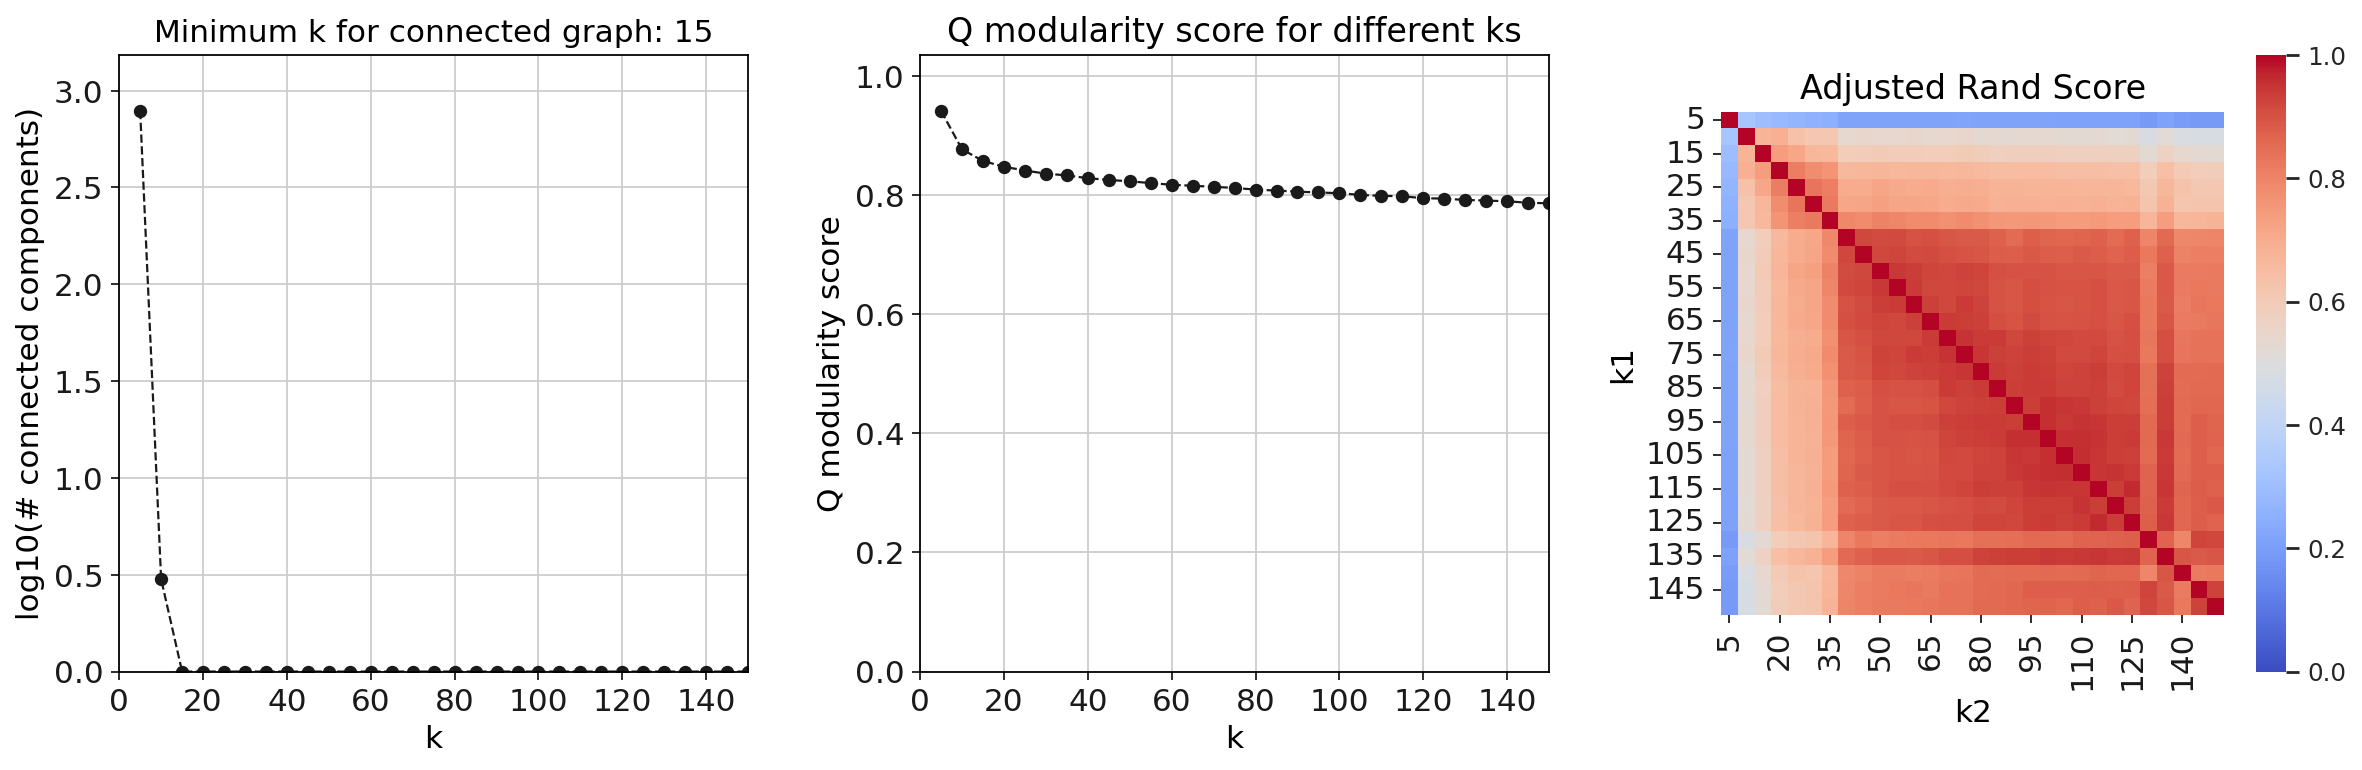

In [24]:
# plot clustering metrics
Rand_index_df = inspect_clustering_chars(ks, cluster_chars)

In [25]:
# print table with rand scores for the different ks
Rand_index_df.iloc[1:10,1:15]

k2        10        15        20        25        30        35        40  \
k1                                                                         
10  1.000000  0.675855  0.691331  0.633054  0.613862  0.614666  0.537740   
15  0.675855  1.000000  0.741454  0.715105  0.669362  0.664712  0.593022   
20  0.691331  0.741454  1.000000  0.813564  0.777534  0.764393  0.660659   
25  0.633054  0.715105  0.813564  1.000000  0.834682  0.812090  0.699492   
30  0.613862  0.669362  0.777534  0.834682  1.000000  0.823939  0.718500   
35  0.614666  0.664712  0.764393  0.812090  0.823939  1.000000  0.790967   
40  0.537740  0.593022  0.660659  0.699492  0.718500  0.790967  1.000000   
45  0.543685  0.594160  0.671602  0.699803  0.719513  0.784130  0.920365   
50  0.542161  0.601755  0.673707  0.720452  0.731637  0.801213  0.913330   

k2        45        50        55        60        65        70        75  
k1                                                                        
10  0.543685  0.542161  0.539197  0.543306  0.538511  0.540511  0.544136  
15  0.594160  0.601755  0.595621  0.596942  0.592836  0.592827  0.598153  
20  0.671602  0.673707  0.666327  0.669401  0.668965  0.666937  0.668934  
25  0.699803  0.720452  0.709766  0.700322  0.703188  0.694672  0.698931  
30  0.719513  0.731637  0.721280  0.721272  0.715271  0.702607  0.708089  
35  0.784130  0.801213  0.793341  0.784400  0.781931  0.772788  0.782113  
40  0.920365  0.913330  0.917778  0.900699  0.905548  0.890695  0.885187  
45  1.000000  0.919759  0.925740  0.912800  0.915297  0.904166  0.895808  
50  0.919759  1.000000  0.944135  0.935433  0.925266  0.920418  0.928699

🕹️ Using the heatmap and table above choose a value for k. 

As rule of thumb, choose a connected graph k with an adjusted Rand score >=0.8 for 4 consecutive steps. 

In [44]:
# run unsupervised clustering analysis with PhenoGraph
k=40 # add your selected k value here
communities, graph, Q = sc.external.tl.phenograph(pd.DataFrame(adata.obsm['X_pca']),k=k)
adata.obs['PhenoGraph_clusters'] = pd.Categorical(communities)
adata.uns['PhenoGraph_Q'] = Q
adata.uns['PhenoGraph_k'] = k

Finding 40 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 8.76203441619873 seconds
Jaccard graph constructed in 36.20986747741699 seconds
Wrote graph to binary file in 1.20267915725708 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.826846
After 3 runs, maximum modularity is Q = 0.828245
Louvain completed 23 runs in 34.52179670333862 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 100.04448652267456 seconds


We can visualize the clustering to see which clusters match with the cells that we would like to filter out. Inspect the list of QC metrics and canonical markers to make your choice.

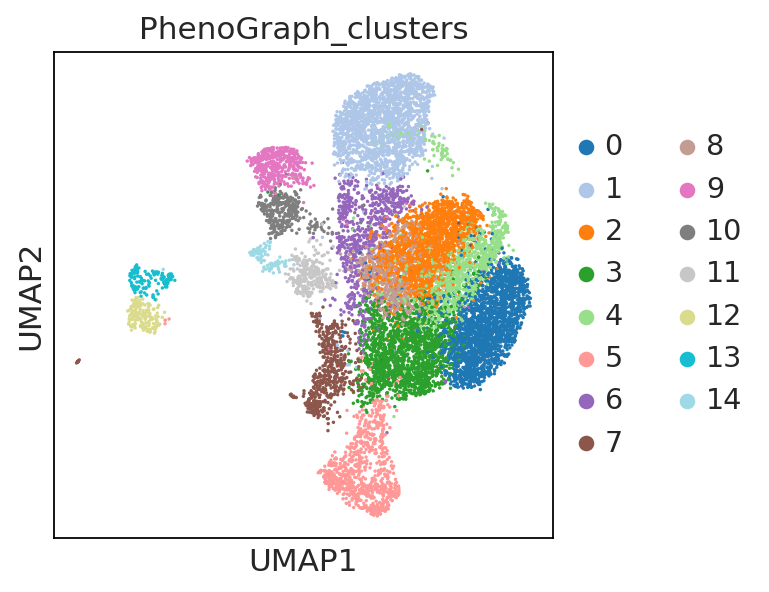

In [45]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata, 
    color=['PhenoGraph_clusters'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

### Filtering out cells: by cluster

Now inspect tha QC metrics for each of the clusters and choose to remove any clusters that may have a combination of bad quality metrics.

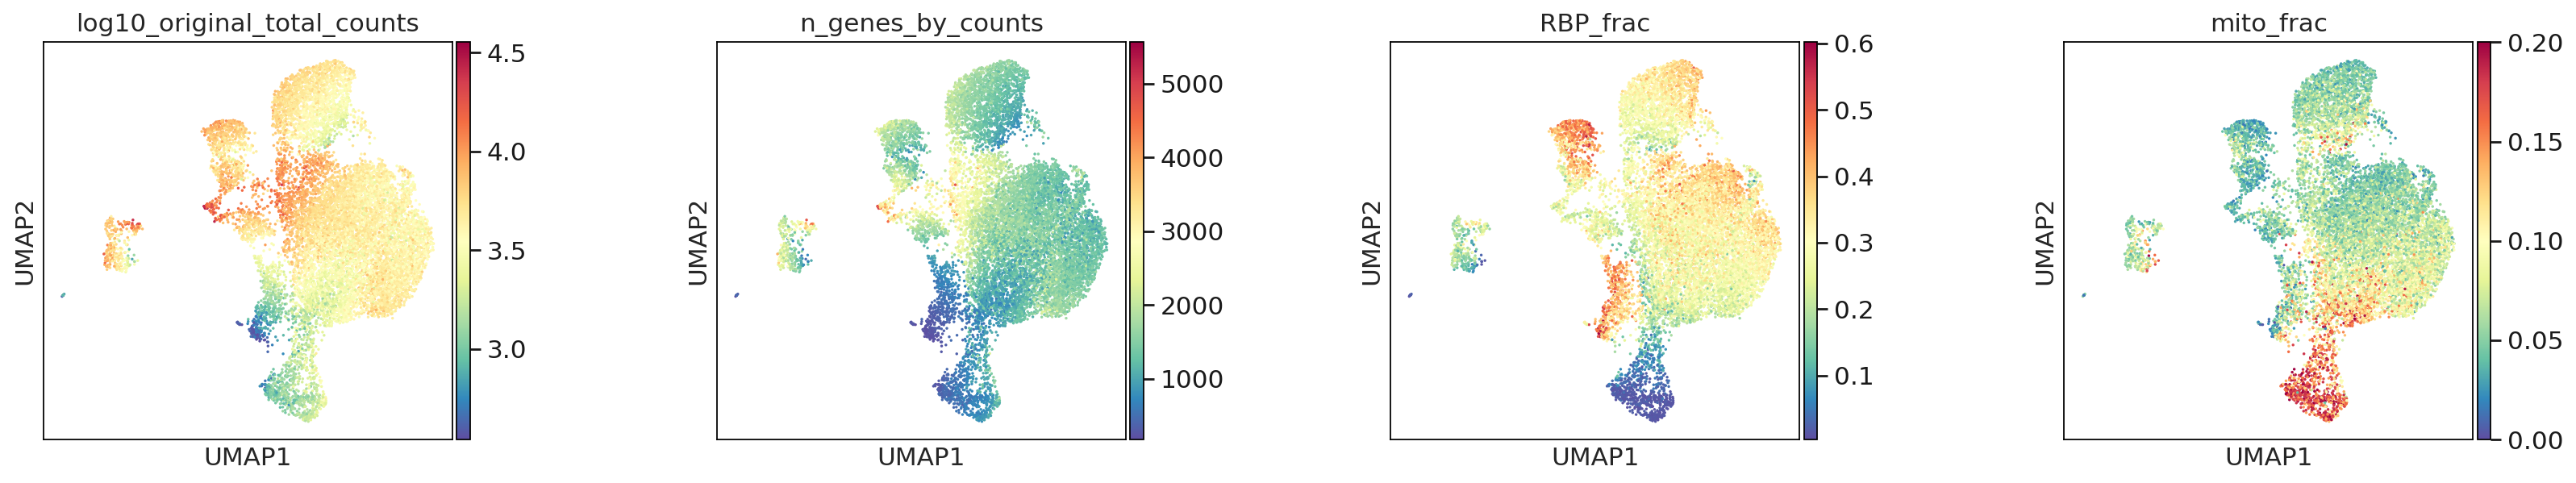

In [46]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

In [47]:
adata.shape

(12427, 18077)

Choose which clusters you want to remove, and add them to the list clusters_to_remove below.

In [55]:
clusters_to_remove = [3, 5, 7]
cluster_filter = [x not in clusters_to_remove for x in adata.obs['PhenoGraph_clusters']]
print('Total number of cells pre-filtering: ' + str(adata.shape[0]))
print('Number of cells to keep after filtering: ' + str(sum(cluster_filter)))
adata_filtered = adata[cluster_filter]

Total number of cells pre-filtering: 12427
Number of cells to keep after filtering: 9349


Check if the right clusters were removed.

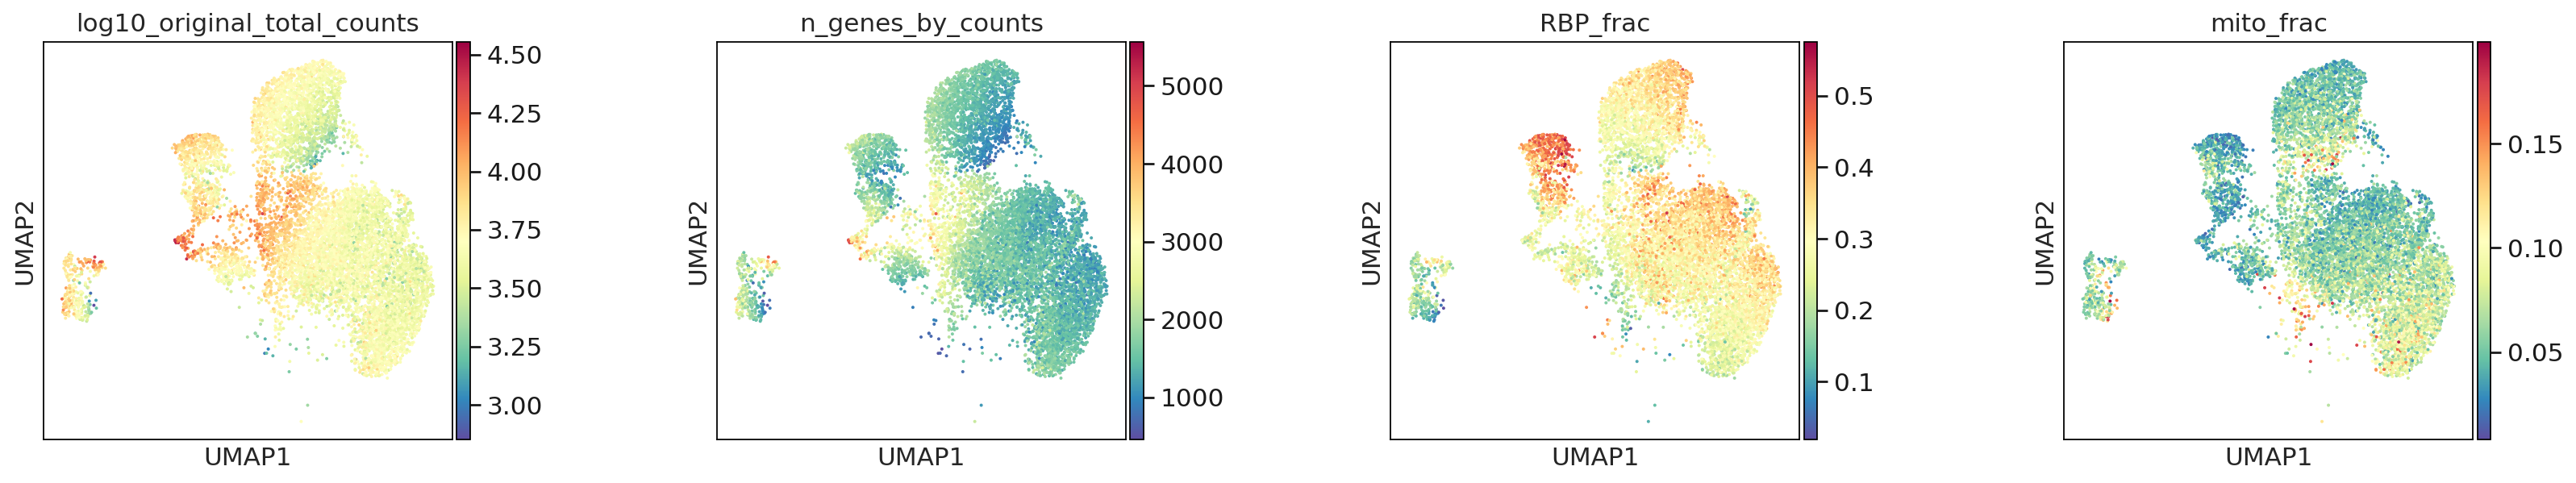

In [57]:
sc.set_figure_params(dpi=80, dpi_save=300, color_map='viridis', vector_friendly=False, transparent=True)
sc.pl.umap(
    adata_filtered, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.5,
    sort_order = False
)

If the right clusters and doublets were removed continue in the next line to store the result in your adata object.

In [58]:
adata = adata_filtered

In [59]:
adata.shape

(9349, 18077)

### Filtering out cells: doublets and contaminants

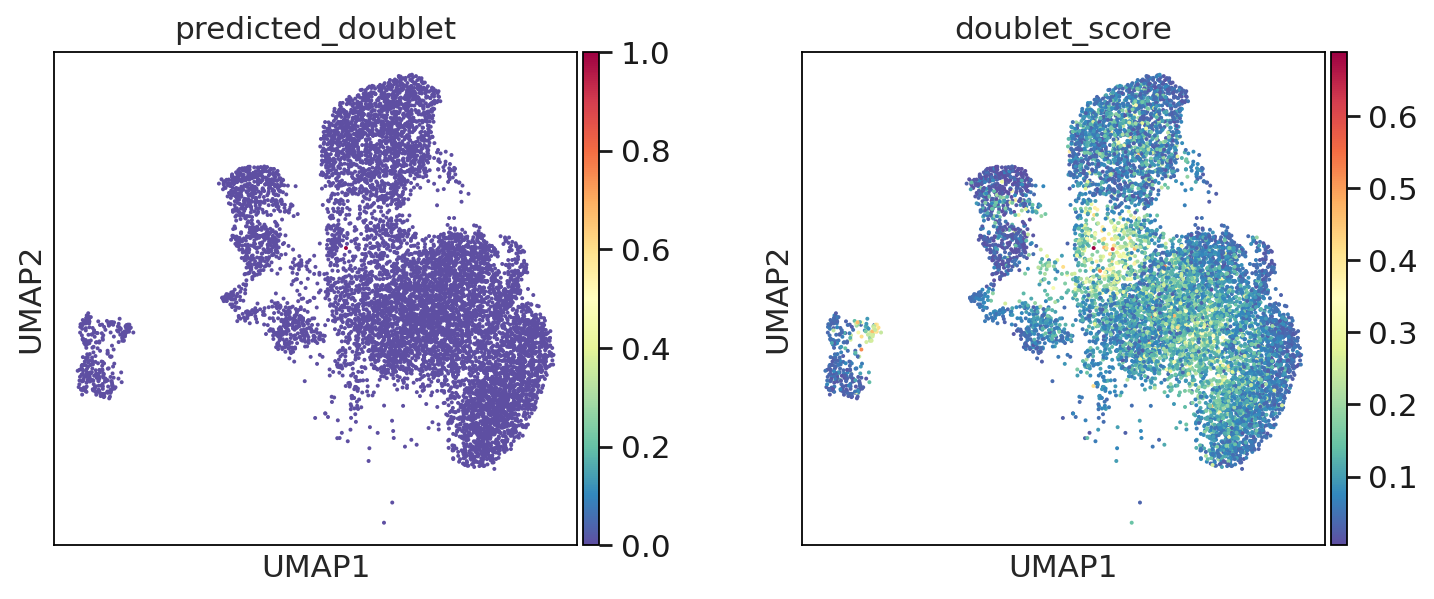

In [60]:
sc.pl.umap(
    adata_filtered, 
    color=['predicted_doublet', 'doublet_score'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

This would be also a good spot to remove the doublets you have identified above or any other cell population that does not match your experimental strategy

In [61]:
adata = adata[adata.obs['predicted_doublet'] == False]

In [62]:
sc.pl.umap(
    adata, 
    color=['predicted_doublet', 'doublet_score'], 
    palette='tab20',  
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

Let's now inspect if the right number of doublet cells has been removed from the dataset.

In [63]:
adata.shape

(9347, 18077)

### Reanalyze data after removal of cells

Once we have removed all unwanted cells, we need to reanalyze our data in a similar way to steps 4 and 5. 

In [64]:
rng = np.random.RandomState(42)
adata = sc.tl.pca(adata, n_comps=200, copy = True, svd_solver='arpack', random_state=rng)

In [65]:
observe_variance(adata)

<function matplotlib.pyplot.show(close=None, block=None)>

🕹️ Remember to choose a different number of principal components based on the re-analysis

In [66]:
rng = np.random.RandomState(42)
sc.tl.pca(adata, n_comps=30, svd_solver='arpack', random_state=rng)

In [67]:
sc.pp.neighbors(adata, n_neighbors=15)

In [68]:
sc.tl.umap(adata)

In [69]:
sc.pl.umap(
    adata, 
    color=['log10_original_total_counts', 'n_genes_by_counts','RBP_frac', 'mito_frac'], 
    palette='tab20', 
    color_map='Spectral_r', 
    ncols=4,
    wspace = 0.3,
    sort_order = False
)

You are done! Just save you file and save the index of you cells. You can now come back to this dataset at anytime.

PS. For more visualization options check the scanpy tutorials.

In [73]:
path_to_h5ad = '/home/kousaa/scRNAseq-analysis/[AK011] Hana_unconvencional-Tcells/notebooks/files/MAIT_patients.h5ad'

In [74]:
adata.write(path_to_h5ad)

In [ ]:
adata = sc.read_h5ad(path_to_h5ad)

In [75]:
# save index of your good quality cells for future use
QCpassed_cells = adata.obs.index
QCpassed_cellsDF = pd.DataFrame(QCpassed_cells)
QCpassed_cellsDF.to_pickle('files/MAIT_patients_QCpassed.pkl')

In [76]:
%load_ext watermark

In [77]:
%watermark

Last updated: 2021-11-09T15:47:49.279967-05:00

Python implementation: CPython
Python version       : 3.8.12
IPython version      : 7.29.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 3.10.0-957.12.2.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 72
Architecture: 64bit

